In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn as sk
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/injury-prediction-for-competitive-runners/day_approach_maskedID_timeseries.csv
/kaggle/input/injury-prediction-for-competitive-runners/week_approach_maskedID_timeseries.csv


In order to fully understand the Dataset, I read the researchers Read_Me text file, which I will copy and paste here to make understanding the variables easier 


Injury Prediction In Competitive Runners With Machine Learning - Datasets

This work encompasses two datasets uploaded to Dataverse:

1. day_approach_maskedID_timeseries.csv, corresponding to the day approach
2. week_approach_maskedID_timeseries.csv, corresponding to the week approach

All features are described in detail in our paper:
Lövdal, Azzopardi, den Hartigh, "Injury Prediction in Competitive Runners With Machine Learning", International journal of sports physiology and performance, 2020


The features pertaining to training load and/or recovery are expressed as a 
time series covering seven individual days for the day approach, 
and three weeks with features aggregated on a weekly level for the week approach.

####################################################################################

For the day approach the features for a specific day are the following:

nr. sessions (number of trainings completed)
total km (number of kilometers covered by running)
km Z3-4 (number of kilometers covered in intensity zones three and four,
	above the aerobic threshold but below the anaerobic)
km Z5-T1-T2 (number of kilometers covered in intensity zone five, above the
	     anaerobic threshold, or intensive track intervals 
	     (T1 for longer repetitions and T2 for shorter)
km sprinting (number of kilometers covered with sprints)
strength training (whether the day included a strength training)
hours alternative (number of hours spent on cross training)
perceived exertion (athlete's own estimation of how tired they were after 
		   completing the main session of the day. In case of of a 
		   rest day, this value will be -0.01)
perceived trainingSuccess (athlete's own estimation of how well the session went.
			   In case of of a rest day, this value will be -0.01)
perceived recovery (athlete's own estimation of how well rested they felt before
	 	    the start of the session. In case of of a 
		   rest day, this value will be -0.01)

####################################################################################

For the week approach the summarized features for a specific week are the following:

nr. sessions (total number of sessions completed)
nr. rest days (number of days without a training)
total kms (total running mileage)
max km one day (the maximum number of kilometers completed by running on a single day)
total km Z3-Z4-Z5-T1-T2 (the total number of kilometers done in Z3 or faster, corresponding to
			running above the aerobic threshold)
nr. tough sessions (effort in Z5, T1, T2, corresponding to running above the anaerobic threshold
		    and/or intensive track intervals)
nr. days with interval session (number of days that contained a session in Z3 or faster)
total km Z3-4 (number of kilometers covered in Z3-4, between the aerobic and anaerobic threshold)
max km Z3-4 one day (furthest distance ran in Z3-4 on a single day)
total km Z5-T1-T2 (total distance ran in Z5-T1-T2)
max km Z5-T1-T2 one day (furthest distance ran in Z5-T1-T2 on a single day)
total hours alternative training (total time spent on cross training)
nr. strength trainings (number of strength trainings completed)
avg exertion (the average rating in exertion based on the athlete's own perception of how
	      tough each training has been)
min exertion (the smallest rating in exertion of all trainings of the week)
max exertion (the highest rating in exertion of all trainings of the week)
avg training success (the average rating in how well each training went, according to
		      the athlete's own perception)
min training success (the smallest rating in training success of the week)
max training success (the highest rating in training success of the week)
avg recovery (the average rating in how well rested the athlete felt before each session)
min recovery (the smallest rating in how well rested the athlete felt before a session)
max recovery (the highest rating in how well rested the athlete felt before a session)

####################################################################################

The features are numbered according to how many days (or weeks) before the event 
day (injury or no injury) they occurred, starting the count from 0.
So nr. sessions indicates the number of
sessions completed the day before the event day, nr.sessions.1 the number 
of sessions completed two days before the event day, and so on.
For the week approach the suffix ".1" means the week starting two 
weeks before the injury, and the suffix ".2" the week starting three weeks before
the event day. 

Furthermore, both data sets include a binary column indicating whether 
this training setup resulted in an injury (1) or not (0). The Athlete ID 
is an indicator for different athletes, and the date column indicates the 
event day, relative to the first record in the data set.

In [2]:
week_all = pd.read_csv("/kaggle/input/injury-prediction-for-competitive-runners/week_approach_maskedID_timeseries.csv")
week_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42798 entries, 0 to 42797
Data columns (total 72 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   nr. sessions                                   42798 non-null  float64
 1   nr. rest days                                  42798 non-null  float64
 2   total kms                                      42798 non-null  float64
 3   max km one day                                 42798 non-null  float64
 4   total km Z3-Z4-Z5-T1-T2                        42798 non-null  float64
 5   nr. tough sessions (effort in Z5, T1 or T2)    42798 non-null  float64
 6   nr. days with interval session                 42798 non-null  float64
 7   total km Z3-4                                  42798 non-null  float64
 8   max km Z3-4 one day                            42798 non-null  float64
 9   total km Z5-T1-T2                              427

In [3]:
np.random.seed(0)

In [4]:
missing_Values = week_all.isnull().sum()
missing_Values 

nr. sessions               0
nr. rest days              0
total kms                  0
max km one day             0
total km Z3-Z4-Z5-T1-T2    0
                          ..
injury                     0
rel total kms week 0_1     0
rel total kms week 0_2     0
rel total kms week 1_2     0
Date                       0
Length: 72, dtype: int64

In [5]:
week_all.describe()

,nr. sessions,nr. rest days,total kms,max km one day,total km Z3-Z4-Z5-T1-T2,"nr. tough sessions (effort in Z5, T1 or T2)",nr. days with interval session,total km Z3-4,max km Z3-4 one day,total km Z5-T1-T2,...,max training success.2,avg recovery.2,min recovery.2,max recovery.2,Athlete ID,injury,rel total kms week 0_1,rel total kms week 0_2,rel total kms week 1_2,Date
count,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,...,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,4.279800e+04,4.279800e+04,4.279800e+04,42798.000000
mean,5.809337,1.874667,49.543911,14.009255,9.433621,0.930184,1.672531,4.859398,3.456888,4.063970,...,0.525709,0.255089,0.184927,0.343522,34.538249,0.013435,4.408628e+05,9.014685e+05,4.803623e+05,1227.733422
std,2.484234,1.853287,36.715017,9.071678,8.887120,1.040631,1.263528,6.984670,4.577423,5.645305,...,0.390604,0.153214,0.127996,0.219536,19.020826,0.115130,4.328234e+06,6.945503e+06,4.656806e+06,806.495152
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,5.000000,1.000000,22.800000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.150000,0.110000,0.170000,20.000000,0.000000,6.955245e-01,6.723968e-01,6.923077e-01,437.000000
50%,6.000000,1.000000,44.800000,13.400000,8.000000,1.000000,2.000000,0.000000,0.000000,1.500000,...,0.730000,0.220000,0.160000,0.310000,34.000000,0.000000,9.891862e-01,1.001431e+00,9.897523e-01,1254.000000
75%,7.000000,3.000000,70.100000,18.300000,14.600000,2.000000,3.000000,8.000000,6.300000,6.300000,...,0.840000,0.360000,0.240000,0.520000,50.000000,0.000000,1.320515e+00,1.422171e+00,1.327586e+00,1913.000000
max,14.000000,7.000000,242.000000,131.000000,100.000000,6.000000,7.000000,79.800000,75.000000,80.000000,...,1.000000,0.900000,0.900000,1.000000,73.000000,1.000000,2.096000e+08,2.176000e+08,2.096000e+08,2673.000000


In [6]:
week_all.head(10)

,nr. sessions,nr. rest days,total kms,max km one day,total km Z3-Z4-Z5-T1-T2,"nr. tough sessions (effort in Z5, T1 or T2)",nr. days with interval session,total km Z3-4,max km Z3-4 one day,total km Z5-T1-T2,...,max training success.2,avg recovery.2,min recovery.2,max recovery.2,Athlete ID,injury,rel total kms week 0_1,rel total kms week 0_2,rel total kms week 1_2,Date
0,5.0,2.0,22.2,16.4,11.8,1.0,2.0,10.0,10.0,0.6,...,0.0,0.18,0.16,0.20,0,0,0.718447,1.378882,1.919255,0
1,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.18,0.16,0.20,0,0,0.683544,1.018868,1.490566,1
2,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.17,0.16,0.18,0,0,0.683544,1.018868,1.490566,2
3,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.18,0.16,0.18,0,0,0.683544,1.018868,1.490566,3
4,6.0,1.0,39.2,17.6,18.9,1.0,3.0,17.2,10.0,0.5,...,0.0,0.17,0.16,0.18,0,0,2.202247,1.361111,0.618056,4
5,6.0,1.0,39.2,17.6,18.9,1.0,3.0,17.2,10.0,0.5,...,0.0,0.17,0.16,0.18,0,0,2.202247,1.361111,0.618056,5
6,6.0,1.0,33.3,17.6,15.4,1.0,3.0,13.7,7.2,0.5,...,0.0,0.17,0.16,0.18,0,0,1.500000,1.077670,0.718447,6
7,5.0,2.0,33.3,17.6,15.4,1.0,3.0,13.7,7.2,0.5,...,0.0,0.17,0.16,0.18,0,0,1.500000,1.077670,0.718447,7
8,5.0,2.0,32.9,17.6,15.5,0.0,3.0,14.3,7.2,0.0,...,0.0,0.17,0.16,0.18,0,0,1.523148,1.041139,0.683544,8
9,5.0,2.0,32.9,17.6,15.5,0.0,3.0,14.3,7.2,0.0,...,0.0,0.17,0.16,0.18,0,0,1.523148,1.041139,0.683544,9


In [7]:
week_all['Athlete ID'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73])

In total there are 74 athletes. Let's isolate the first athlete and see what their training looks like.


In [8]:
first_athlete = week_all[week_all['Athlete ID'] == 0]
first_athlete

,nr. sessions,nr. rest days,total kms,max km one day,total km Z3-Z4-Z5-T1-T2,"nr. tough sessions (effort in Z5, T1 or T2)",nr. days with interval session,total km Z3-4,max km Z3-4 one day,total km Z5-T1-T2,...,max training success.2,avg recovery.2,min recovery.2,max recovery.2,Athlete ID,injury,rel total kms week 0_1,rel total kms week 0_2,rel total kms week 1_2,Date
0,5.0,2.0,22.2,16.4,11.8,1.0,2.0,10.0,10.0,0.6,...,0.0,0.18,0.16,0.20,0,0,0.718447,1.378882,1.919255,0
1,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.18,0.16,0.20,0,0,0.683544,1.018868,1.490566,1
2,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.17,0.16,0.18,0,0,0.683544,1.018868,1.490566,2
3,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.18,0.16,0.18,0,0,0.683544,1.018868,1.490566,3
4,6.0,1.0,39.2,17.6,18.9,1.0,3.0,17.2,10.0,0.5,...,0.0,0.17,0.16,0.18,0,0,2.202247,1.361111,0.618056,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42225,1.0,6.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.18,0.18,0.18,0,1,0.424242,1.076923,2.538461,386
42226,7.0,0.0,47.2,12.5,14.7,0.0,3.0,14.0,6.0,0.0,...,0.0,0.17,0.15,0.18,0,1,0.810997,1.053571,1.299107,413
42227,9.0,1.0,29.4,7.5,3.9,3.0,3.0,0.0,0.0,2.5,...,0.0,0.18,0.17,0.18,0,1,0.794595,1.017301,1.280277,461
42228,7.0,0.0,28.5,6.9,10.8,1.0,4.0,10.0,4.5,0.8,...,0.0,0.17,0.16,0.17,0,1,1.619318,0.823699,0.508671,490


It seems that the way the data is organized is that the injury are at the end of the data set for each athlete. 

<AxesSubplot:ylabel='total kms'>

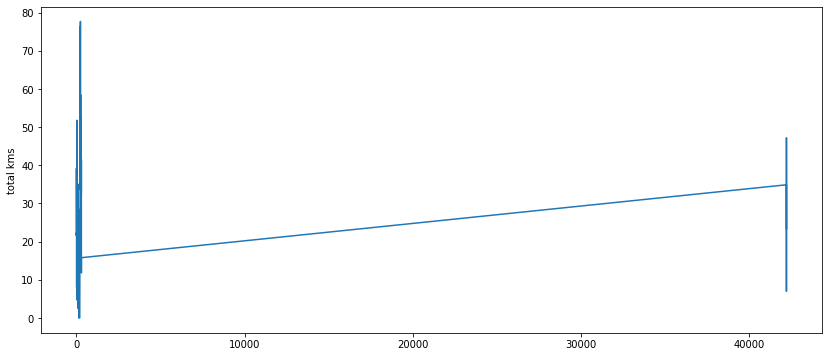

In [9]:
plt.figure(figsize=(14,6))
sns.lineplot(data=first_athlete['total kms'])

Here we can see that the data of the athlete before injury is at the front of the data set, and then post-injury reapers at the end. Let's look at the pre-injured time line and post-injured time line seperately to get a better visualization of the data. 

<AxesSubplot:ylabel='total kms'>

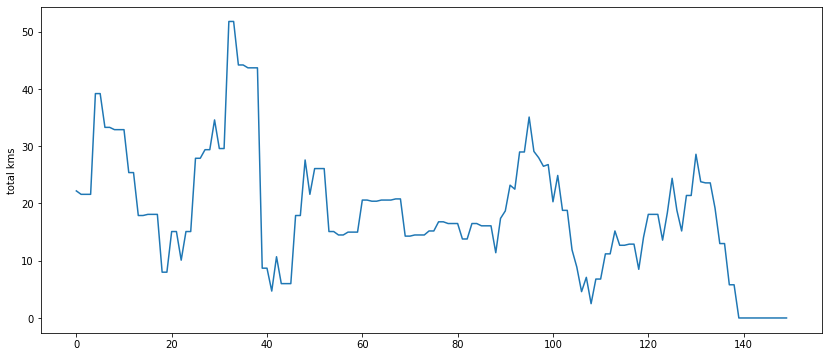

In [10]:
plt.figure(figsize=(14,6))
sns.lineplot(data=first_athlete['total kms'].head(150))

Here we can see that the first athlete was able to get in 130 weeks of training before getting injured

<AxesSubplot:ylabel='total kms'>

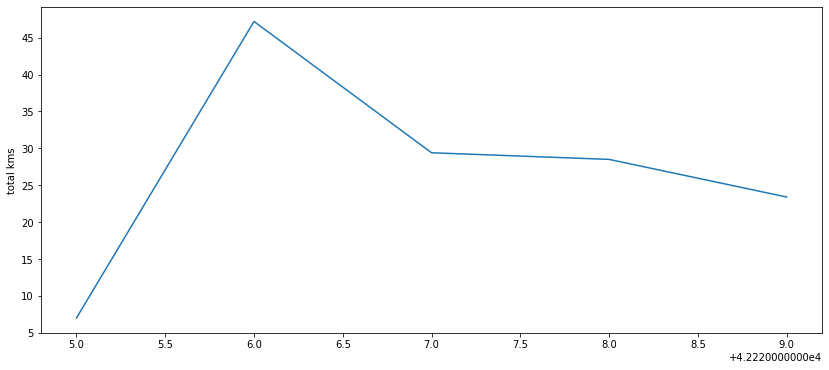

In [11]:
plt.figure(figsize=(14,6))
sns.lineplot(data=first_athlete['total kms'].tail())

So what we need to do is predict the runner's injury based on the date. The two biggest factors to knowing wether a runner is injured or not depends on the amount run and the amount of time taken off. 

In [12]:
(first_athlete["injury"]==1).sum()

7

In [13]:
(first_athlete["injury"]==0).sum()

303

The first athlete has 7 total injured weeks and 303 non injured weeks. 

<AxesSubplot:ylabel='total kms'>

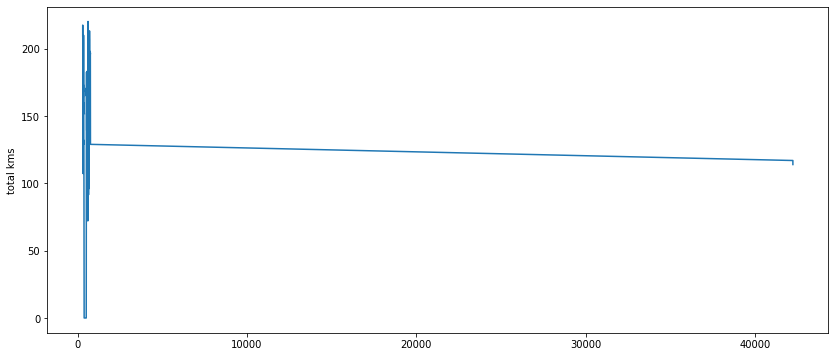

In [14]:
second_athlete = week_all[week_all['Athlete ID'] == 1]
plt.figure(figsize=(14,6))
sns.lineplot(data=second_athlete['total kms'])

<AxesSubplot:ylabel='total kms'>

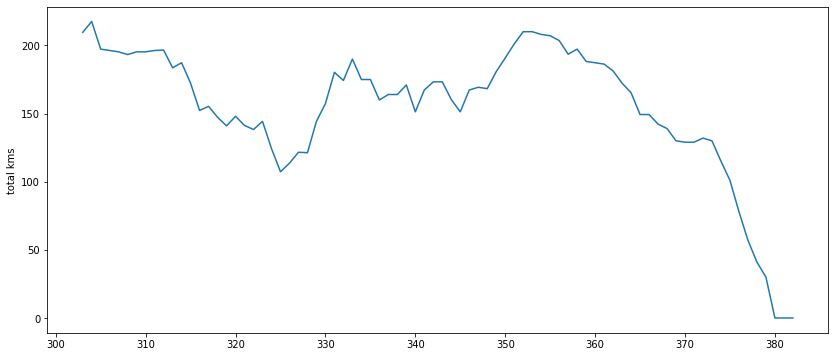

In [15]:
plt.figure(figsize=(14,6))
sns.lineplot(data=second_athlete['total kms'].head(80))

It seems that the second athlete was able to go 80 weeks before getting injured 

<AxesSubplot:ylabel='total kms.2'>

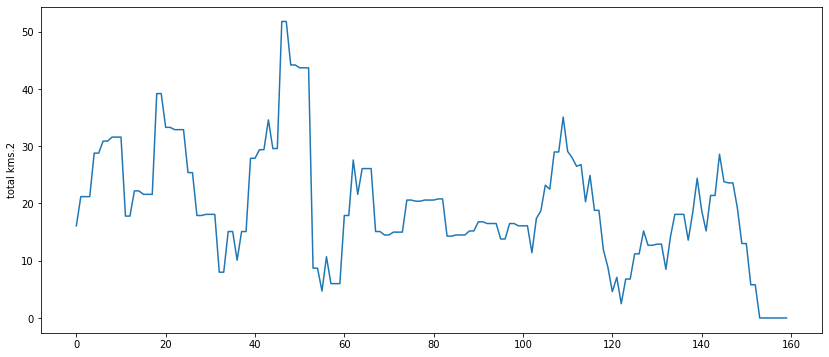

In [16]:
plt.figure(figsize=(14,6))
sns.lineplot(data=first_athlete['total kms.2'].head(160))

In [17]:
y = week_all['injury']
X = week_all.drop('injury', axis=1)
X = week_all.drop('Athlete ID', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.3, random_state = 0)

K = []
training = []
test = []
scores = {}
  
for k in range(2, 21):
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train, y_train)
  
    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    K.append(k)
  
    training.append(training_score)
    test.append(test_score)
    scores[k] = [training_score, test_score]
    
for keys, values in scores.items():
    print(keys, ':', values)

2 : [0.9873489552039522, 0.9874610591900311]
3 : [0.9877161359236264, 0.9873831775700934]
4 : [0.986481073502904, 0.9874610591900311]
5 : [0.986514453568329, 0.9874610591900311]
6 : [0.9863141731757794, 0.9873052959501558]
7 : [0.9863475532412044, 0.9873052959501558]
8 : [0.9862474130449296, 0.9873052959501558]
9 : [0.9862474130449296, 0.9873052959501558]
10 : [0.9862474130449296, 0.9873052959501558]
11 : [0.9862474130449296, 0.9873052959501558]
12 : [0.9862474130449296, 0.9873052959501558]
13 : [0.9862474130449296, 0.9873052959501558]
14 : [0.9862474130449296, 0.9873052959501558]
15 : [0.9862474130449296, 0.9873052959501558]
16 : [0.9862474130449296, 0.9873052959501558]
17 : [0.9862474130449296, 0.9873052959501558]
18 : [0.9862474130449296, 0.9873052959501558]
19 : [0.9862474130449296, 0.9873052959501558]
20 : [0.9862474130449296, 0.9873052959501558]


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


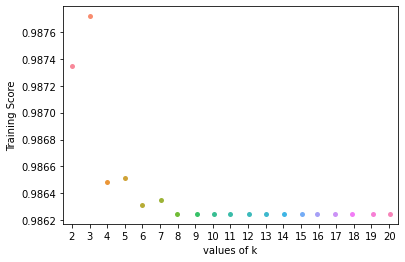

In [18]:
ax = sns.stripplot(K, training);
ax.set(xlabel ='values of k', ylabel ='Training Score')  
  
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


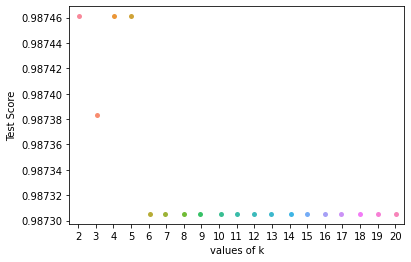

In [19]:
ax = sns.stripplot(K, test);
ax.set(xlabel ='values of k', ylabel ='Test Score')
plt.show()

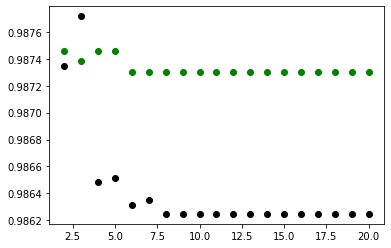

In [20]:
plt.scatter(K, training, color ='k')
plt.scatter(K, test, color ='g')
plt.show()

The KNN model seems optimal to try as our goal is to predict wether someone is injured based on a binary option of 0 or 1. The downside to KNN is that the more features there are the more it over fits, and 73 features is a lot. We could posibly cut down on some features that don't add value to the model. Too high of a KNN k value will lead to overfitting and too low of a k value will lead to underfitting. As we can see over the values 2 to 21, the accuracy does not significantly change. This leads me to believe that it does not overfit or underfit. 